# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Load Data and Preliminary Look

In [2]:
# Load the data
train = pd.read_csv('train.csv')
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Data description :

**id**: Unique ID for the customer

**Gender**: Gender of the customer

**Age**: Age of the customer

**Driving_License** 0 : Customer does not have DL, 1 : Customer already has DL

**Region_Code**: Unique code for the region of the customer

**Previously_Insured** 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

**Vehicle_Age**: Age of the Vehicle

**Vehicle_Damage** 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

**Annual_Premium** : The amount customer needs to pay as premium in the year

**PolicySalesChannel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage**: Number of Days, Customer has been associated with the company

**Response** 1 : Customer is interested, 0 : Customer is not interested

# Data Cleaning

In [4]:
# Check missing value
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [5]:
# Check duplicated value
train.duplicated().sum()

0

In [6]:
# Drop unnecessary column
train = train.drop('id', axis=1)

the data have been clean up. there is no missing and duplicated value and also had drop unnecessary column

# EDA

## Statistical summary

In [7]:
# Group columns by their types
nums = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
        'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']
cats = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [8]:
# statistical summary numeric columns
train[nums].describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


dari kesimpulan statistik kolom numerik diketahui bahwa :

- kolom driving_license, previously_insured, dan Response merupakan value binary
- secara keseluruhan kolom terdistribusi baik
- persebaran min max annual_premium sangat jauh

In [9]:
# statistical summary categoric columns
train[cats].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


## Rasio Customer Response

In [10]:
# count cust group by which has interest and not
response = train['Response'].value_counts()
response

0    334399
1     46710
Name: Response, dtype: int64

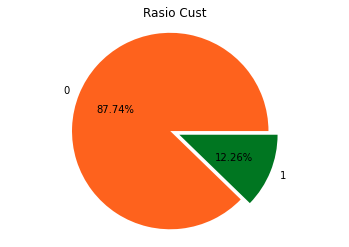

In [11]:
# proportion interest cust
label = response.index
count = response.values
colors=['#fe621d', '#007621']
explode = (0, 0.1)

plt.title('Rasio Cust')
plt.pie(count, labels=label, colors=colors, explode=explode,
        autopct='%1.2f%%')
plt.axis('equal')
plt.show()

## Age feature

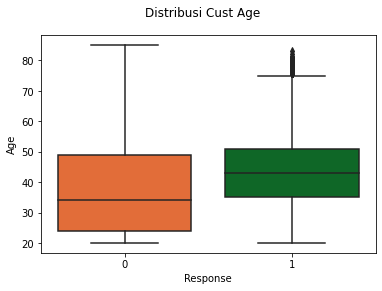

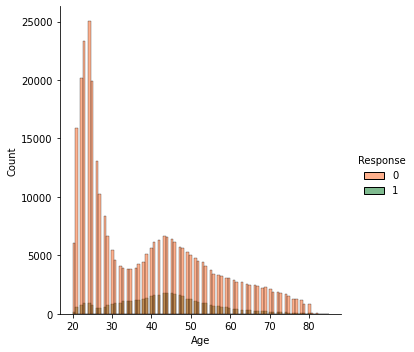

In [12]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Cust Age')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Response'], palette=palette)
plt.show()

In [13]:
# grouping ages
def group_ages(x) :
  if x <= 25 :
    return 'Young'
  elif x > 25 and x < 45 :
    return 'Adult'
  elif x >= 45 and x < 60 :
    return 'Middle Age'
  else :
    return 'Elder'

referensi : https://www.researchgate.net/publication/338842581_A_cross-sectional_study_on_interference_control_age_affects_reactive_control_but_not_proactive_control

In [14]:
train['group_ages'] = train['Age'].apply(group_ages)

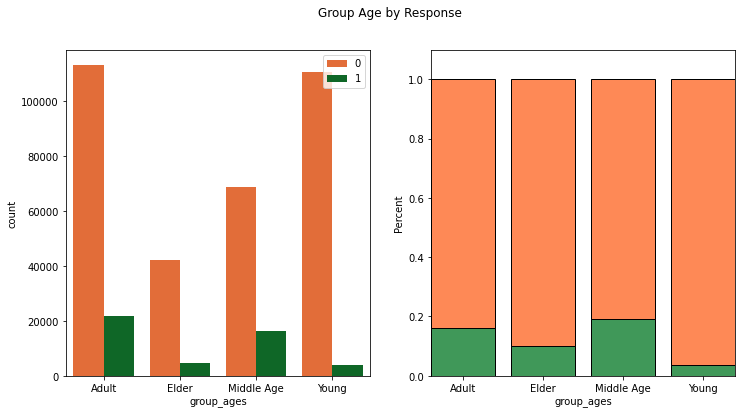

In [15]:
# cek berapa dan persentase cust interested by group age
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Age by Response')

sns.countplot(ax=ax[0], data=train, x=train['group_ages'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_ages'],
              hue=train['Response'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :
- middle age
- dan adult 

mempunyai persentase lebih untuk tertarik ke dalam vehicle insurance. selanjutnya akan cari informasi pendukung untuk menunjang hal tersebut

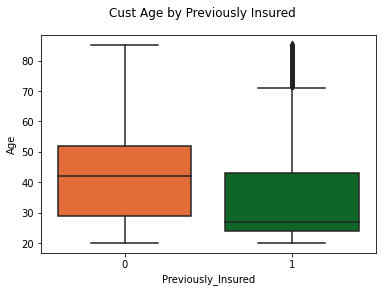

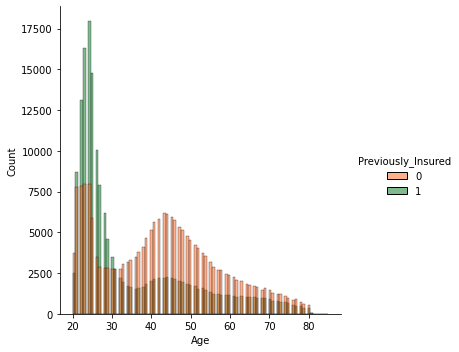

In [16]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Cust Age by Previously Insured')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Previously_Insured'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Previously_Insured'], palette=palette)
plt.show()

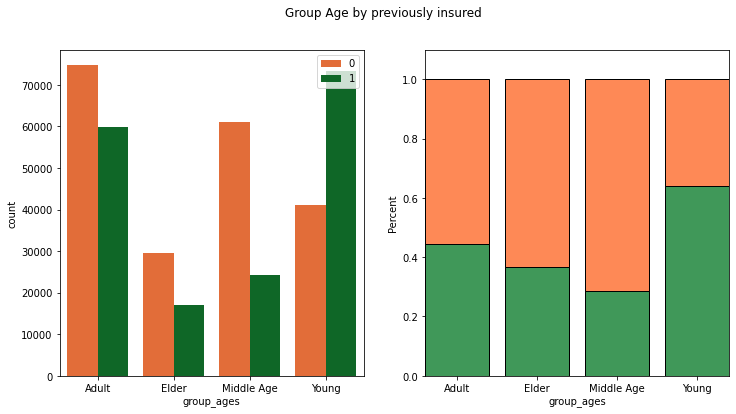

In [17]:
# cek penyebab di beberapa group age memiliki minat berdasar previously insured
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Age by previously insured')

sns.countplot(ax=ax[0], data=train, x=train['group_ages'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_ages'],
              hue=train['Previously_Insured'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :
- kenapa young age tidak berminat karena mereka sudah memiliki vehicle insurance sebelumnya.
- di lain sisi kenapa middle age memiliki minat memang karena sebelumnya sedikit yang memiliki vehicle insurance.

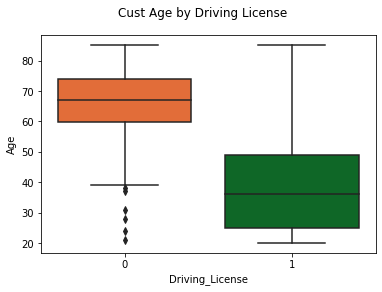

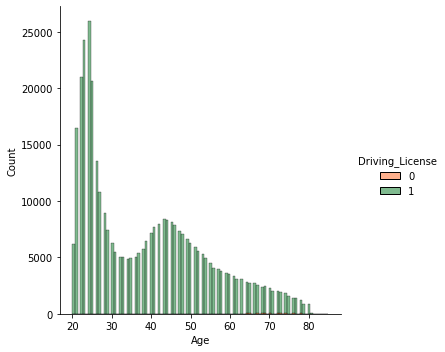

In [18]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Cust Age by Driving License')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Driving_License'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Driving_License'], palette=palette)
plt.show()

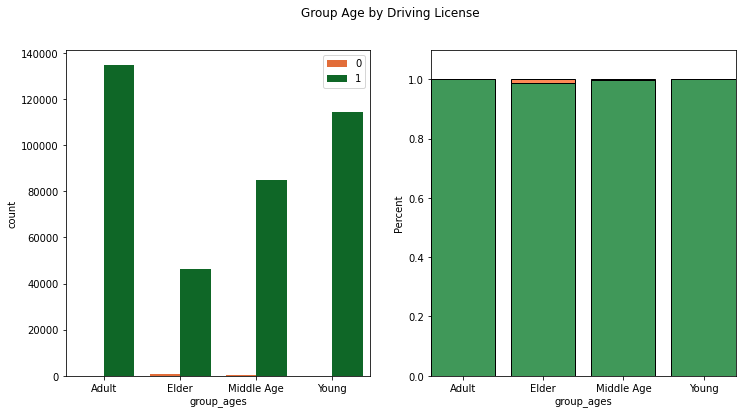

In [19]:
# cek penyebab di beberapa group age memiliki minat berdasar previously insured
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Age by Driving License')

sns.countplot(ax=ax[0], data=train, x=train['group_ages'],
              hue=train['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_ages'],
              hue=train['Driving_License'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

sedikit terlihat bahwa kenapa elder tidak berminat dikarenakan adanya kemungkinan bahwa elder tidak semua memiliki lisensi untuk berkendara

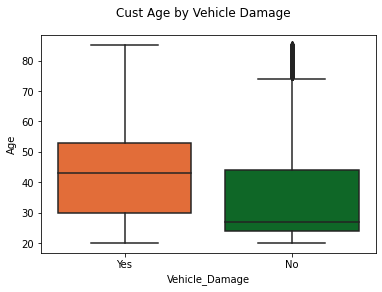

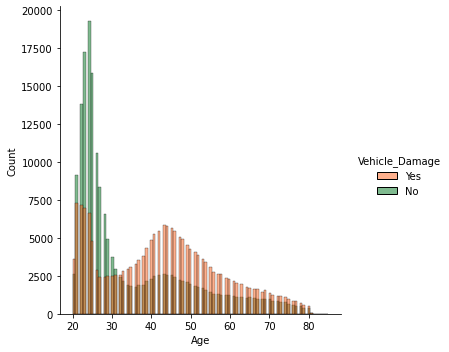

In [20]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Cust Age by Vehicle Damage')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Vehicle_Damage'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Vehicle_Damage'], palette=palette)
plt.show()

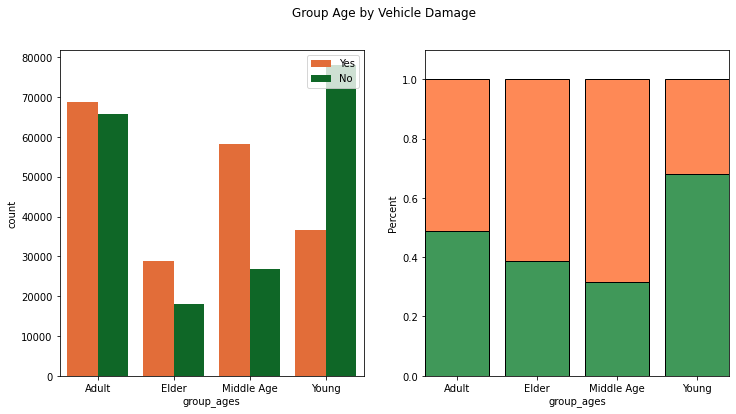

In [21]:
# cek penyebab di beberapa group age memiliki minat berdasar vehicle damage
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Age by Vehicle Damage')

sns.countplot(ax=ax[0], data=train, x=train['group_ages'],
              hue=train['Vehicle_Damage'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_ages'],
              hue=train['Vehicle_Damage'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :
- grup young age memiliki persentase yang lebih dalam vehicle damage akan tetapi mereka sudah memiliki vehicle insurance.
- disini diketahui alasan bahwa grup adult berminat memiliki vehicle insurance karena mereka juga memiliki persentase yang lebih dalam vehicle damage.

## Annual premium feature

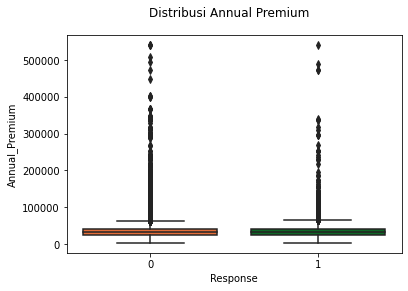

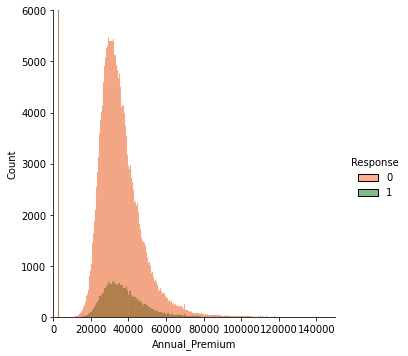

In [22]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Annual Premium')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Annual_Premium'], palette=palette)
sns.displot(x=train['Annual_Premium'], hue=train['Response'], palette=palette)
plt.ylim(0,6000)
plt.xlim(0,150000)
plt.show()

In [23]:
#grouping annual premium into 3 categories
def premium(x) :
  if x <= 25000 :
    return 'Cheap'
  elif x > 25000 and x < 40000 :
    return 'Reguler'
  else :
    return 'Expensive'

In [24]:
train['group_premium'] = train['Annual_Premium'].apply(premium)

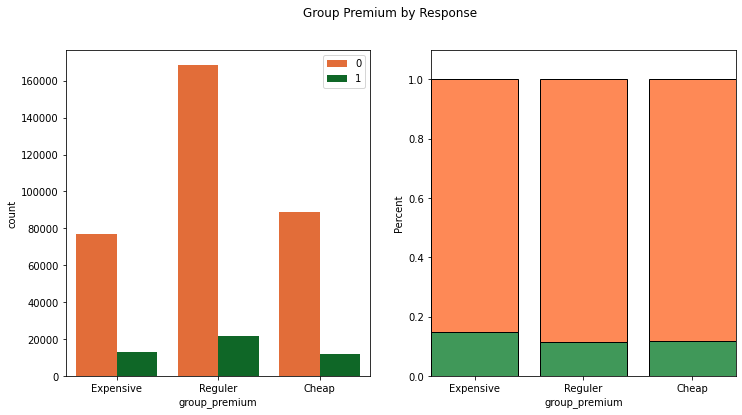

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Premium by Response')

sns.countplot(ax=ax[0], data=train, x=train['group_premium'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_premium'],
              hue=train['Response'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa customer yang annual premium nya di kategorikan sebagai 'Expensive' memiliki persentase lebih dibanding yg lain.

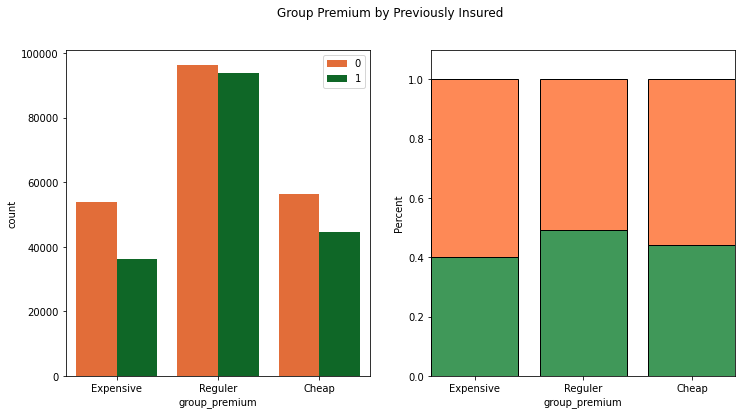

In [26]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Premium by Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['group_premium'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_premium'],
              hue=train['Previously_Insured'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas tsb diketahui bahwa :
- customer yang berani bayar lebih atau di kategorikan sbg 'Expensive' diketahui bahwa sebelumnya tidak memiliki vehicle insurance.
- customer yang biasa-biasa saja atau di kategorikan sbg 'Reguler' diketahui bahwa sebelumnya banyak yang memiliki vehicle insurance.

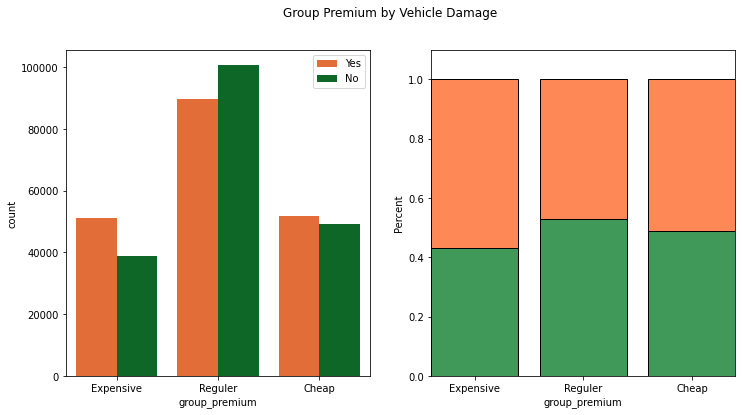

In [27]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Premium by Vehicle Damage')

sns.countplot(ax=ax[0], data=train, x=train['group_premium'],
              hue=train['Vehicle_Damage'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_premium'],
              hue=train['Vehicle_Damage'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas tsb diketahui bahwa :
- kenapa customer kategori 'Reguler' sudah banyak yang memiliki vehicle insurance karena mereka jg memiliki persentase yang lebih dalam mengalami vehicle damage.
- customer yang dikategorikan 'Expensive' justru memiliki persentase yang lebih kecil dalam mengalami vehicle damage.

## Vintage feature

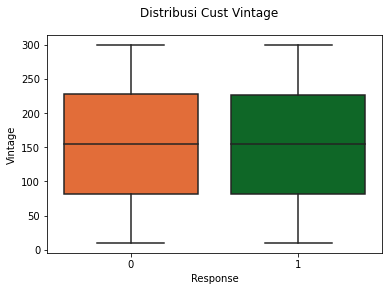

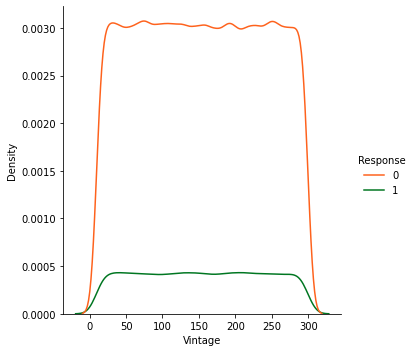

In [28]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Cust Vintage')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Vintage'], palette=palette)
sns.displot(x=train['Vintage'], hue=train['Response'], palette=palette, kind='kde')
plt.show()

In [29]:
# convert vintage days to month
train['datetime'] = pd.to_datetime(train['Vintage'], unit='d')
train['Vintage_Month'] = train['datetime'].dt.month
train = train.drop('datetime', axis=1)

In [30]:
def grup_vintage(x) :
  if x <= 3 :
    return 'New'
  elif x > 3 and x <= 7 :
    return 'Reguler'
  else :
    return 'Loyal'

In [31]:
train['group_vintage'] = train['Vintage_Month'].apply(grup_vintage)

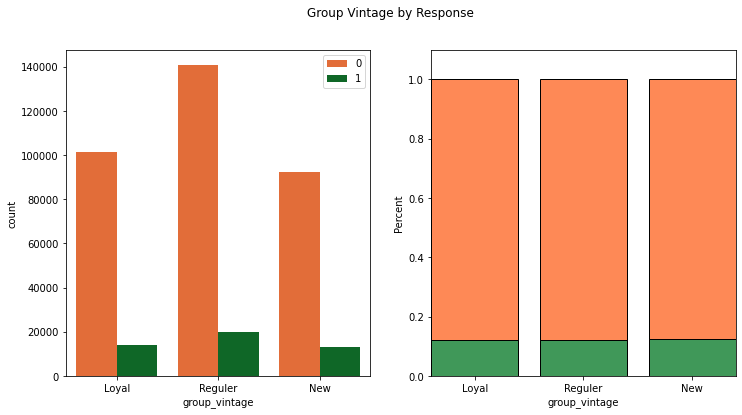

In [32]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Vintage by Response')

sns.countplot(ax=ax[0], data=train, x=train['group_vintage'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['group_vintage'],
              hue=train['Response'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

feature vintage tidak memiliki pengaruh terhadap response customer

## Policy sales channel feature

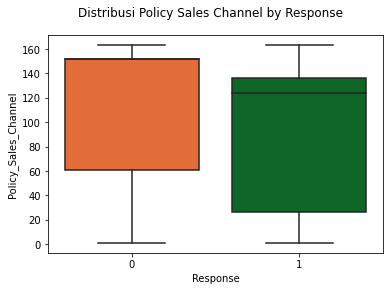

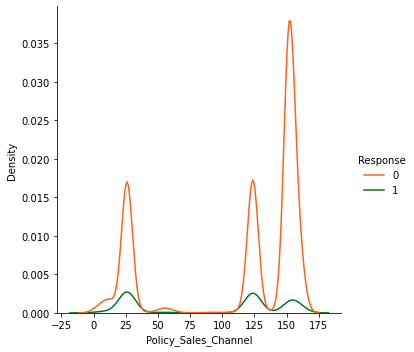

In [33]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Policy Sales Channel by Response')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Policy_Sales_Channel'], palette=palette)
sns.displot(x=train['Policy_Sales_Channel'], hue=train['Response'], palette=palette, kind='kde')
plt.show()

In [34]:
code_policy = train.groupby(['Policy_Sales_Channel', 'Response']).agg(total=('Response', 'count'))

In [35]:
code_policy

total
Policy_Sales_Channel Response       
1.0                  0          1039
                     1            35
2.0                  0             3
                     1             1
3.0                  0           364
...                              ...
159.0                1             1
160.0                0         21304
                     1           475
163.0                0          2013
                     1           880

[274 rows x 1 columns]

In [36]:
pivot = pd.pivot_table(code_policy,
                      index='Policy_Sales_Channel',
                      columns='Response',
                      values='total',
                      aggfunc='sum')

In [37]:
pivot.head()

Response,0,1
Policy_Sales_Channel,,
1.0,1039.0,35.0
2.0,3.0,1.0
3.0,364.0,159.0
4.0,407.0,102.0
6.0,3.0,NaN


In [38]:
pivot.isnull().sum()

Response
0     2
1    34
dtype: int64

In [39]:
pivot[0].fillna(0, inplace=True)
pivot[1].fillna(0, inplace=True)

In [40]:
pivot.isnull().sum()

Response
0    0
1    0
dtype: int64

In [41]:
pivot['total'] = pivot[1] + pivot[0]
pivot['response_rate'] = pivot[1] / pivot['total'] * 100
pivot = pivot.round(2)
pivot.head()

Response,0,1,total,response_rate
Policy_Sales_Channel,,,,
1.0,1039.0,35.0,1074.0,3.26
2.0,3.0,1.0,4.0,25.00
3.0,364.0,159.0,523.0,30.40
4.0,407.0,102.0,509.0,20.04
6.0,3.0,0.0,3.0,0.00


In [42]:
# top 3 response by policy sales channel
pivot.sort_values(1, ascending=False).head(3)

Response,0,1,total,response_rate
Policy_Sales_Channel,,,,
26.0,63809.0,15891.0,79700.0,19.94
124.0,59999.0,13996.0,73995.0,18.91
152.0,130926.0,3858.0,134784.0,2.86


## Region Code feature

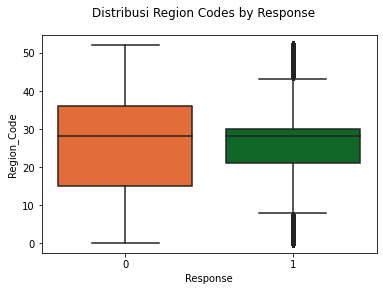

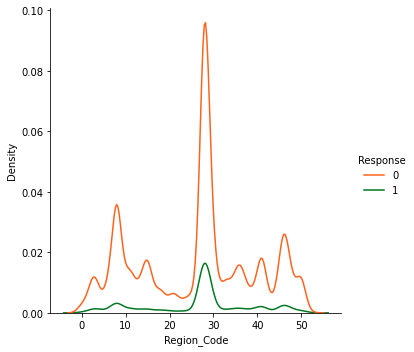

In [43]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Region Codes by Response')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Region_Code'], palette=palette)
sns.displot(x=train['Region_Code'], hue=train['Response'], palette=palette,kind='kde')
plt.show()

In [44]:
region_response = train.groupby(['Region_Code', 'Response']).agg(total=('Response', 'count'))

In [45]:
rs_pivot = pd.pivot_table(region_response,
                      index='Region_Code',
                      columns='Response',
                      values='total',
                      aggfunc='sum')

In [46]:
rs_pivot['total'] = rs_pivot[1] + rs_pivot[0]
rs_pivot['response_rate'] = rs_pivot[1] / rs_pivot['total'] * 100
rs_pivot = rs_pivot.round(2)
rs_pivot.head()

Response,0,1,total,response_rate
Region_Code,,,,
0.0,1847,174,2021,8.61
1.0,899,109,1008,10.81
2.0,3751,287,4038,7.11
3.0,8070,1181,9251,12.77
4.0,1516,285,1801,15.82


In [47]:
# top 3 response by region code
rs_pivot.sort_values(1, ascending=False).head(3)

Response,0,1,total,response_rate
Region_Code,,,,
28.0,86498,19917,106415,18.72
8.0,30620,3257,33877,9.61
41.0,16039,2224,18263,12.18


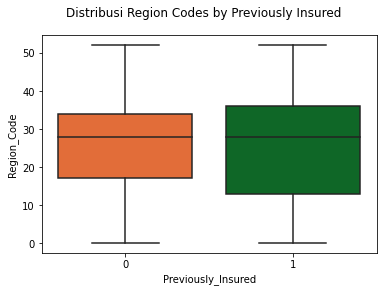

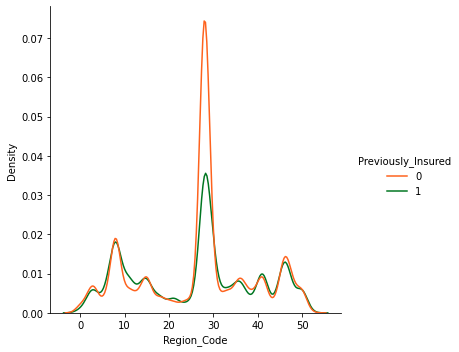

In [48]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Region Codes by Previously Insured')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Previously_Insured'], y=train['Region_Code'], palette=palette)
sns.displot(x=train['Region_Code'], hue=train['Previously_Insured'], palette=palette, kind='kde')
plt.show()

In [49]:
region_previous = train.groupby(['Region_Code', 'Previously_Insured']).agg(
    total=('Previously_Insured', 'count'))

In [50]:
rp_pivot = pd.pivot_table(region_previous,
                      index='Region_Code',
                      columns='Previously_Insured',
                      values='total',
                      aggfunc='sum')

In [51]:
rp_pivot['total'] = rp_pivot[1] + rp_pivot[0]
rp_pivot['response_rate'] = rp_pivot[1] / rp_pivot['total'] * 100
rp_pivot = rp_pivot.round(2)
rp_pivot.head()

Previously_Insured,0,1,total,response_rate
Region_Code,,,,
0.0,1404,617,2021,30.53
1.0,682,326,1008,32.34
2.0,2079,1959,4038,48.51
3.0,4730,4521,9251,48.87
4.0,1047,754,1801,41.87


In [52]:
# top 3 region code by previously insured
rp_pivot.sort_values(0, ascending=False).head(3)

Previously_Insured,0,1,total,response_rate
Region_Code,,,,
28.0,73233,33182,106415,31.18
8.0,16770,17107,33877,50.50
46.0,9456,10293,19749,52.12


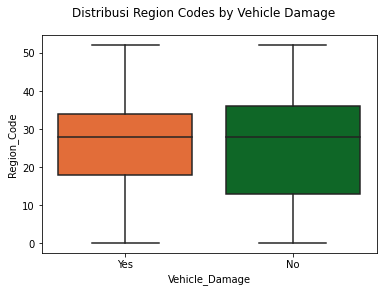

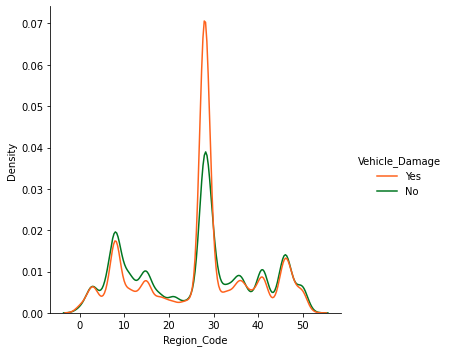

In [53]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Region Codes by Vehicle Damage')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Vehicle_Damage'], y=train['Region_Code'], palette=palette)
sns.displot(x=train['Region_Code'], hue=train['Vehicle_Damage'], palette=palette, kind='kde')
plt.show()

In [54]:
region_damage = train.groupby(['Region_Code', 'Vehicle_Damage']).agg(total=('Vehicle_Damage', 'count'))

In [55]:
rd_pivot = pd.pivot_table(region_damage,
                      index='Region_Code',
                      columns='Vehicle_Damage',
                      values='total',
                      aggfunc='sum')

In [56]:
rd_pivot['total'] = rd_pivot['Yes'] + rd_pivot['No']
rd_pivot['damage_rate'] = rd_pivot['Yes'] / rd_pivot['total'] * 100
rd_pivot = rd_pivot.round(2)
rd_pivot.head()

Vehicle_Damage,No,Yes,total,damage_rate
Region_Code,,,,
0.0,837,1184,2021,58.58
1.0,378,630,1008,62.50
2.0,2199,1839,4038,45.54
3.0,4825,4426,9251,47.84
4.0,790,1011,1801,56.14


In [57]:
# top 3 region code by vehicle damage
rd_pivot.sort_values('Yes', ascending=False).head(3)

Vehicle_Damage,No,Yes,total,damage_rate
Region_Code,,,,
28.0,36179,70236,106415,66.00
8.0,18341,15536,33877,45.86
46.0,10890,8859,19749,44.86


## Previously Insured feature

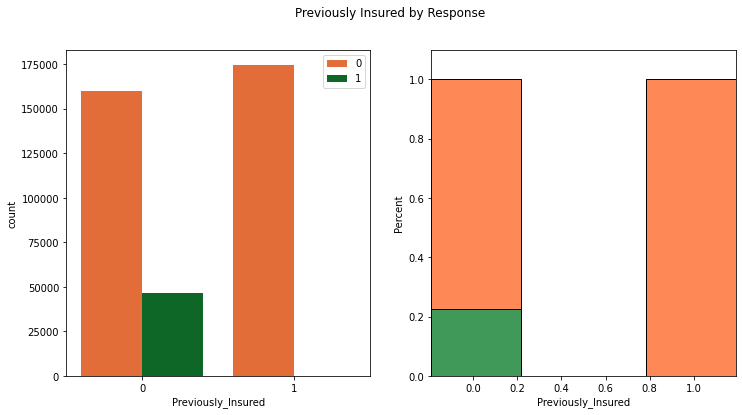

In [58]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Previously Insured by Response')

sns.countplot(ax=ax[0], data=train, x=train['Previously_Insured'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Previously_Insured'],
              hue=train['Response'], stat='percent', multiple='fill',
              shrink=15, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa mereka yang sebelumnya tidak memiliki vehicle insurance sebelumnya memiliki minat untuk bergabung.

## Driving License feature

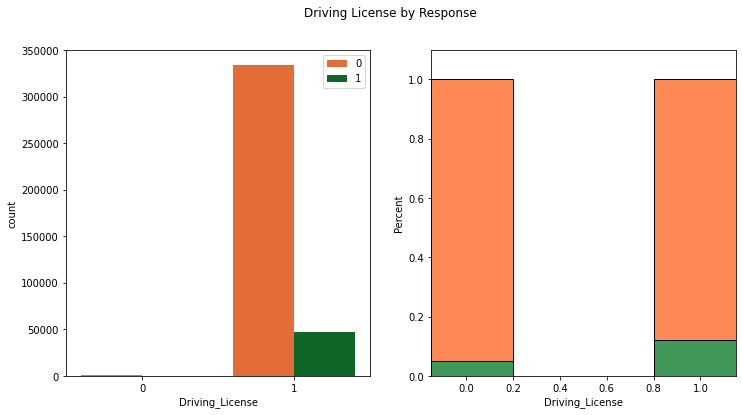

In [59]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Driving License by Response')

sns.countplot(ax=ax[0], data=train, x=train['Driving_License'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Driving_License'],
              hue=train['Response'], stat='percent', multiple='fill',
              shrink=7, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas terlihat bahwa jelas mereka memiliki lisensi berkendara memiliki persentase yang lebih tinggi untuk memiliki vehicle insurance.

## Gender feature

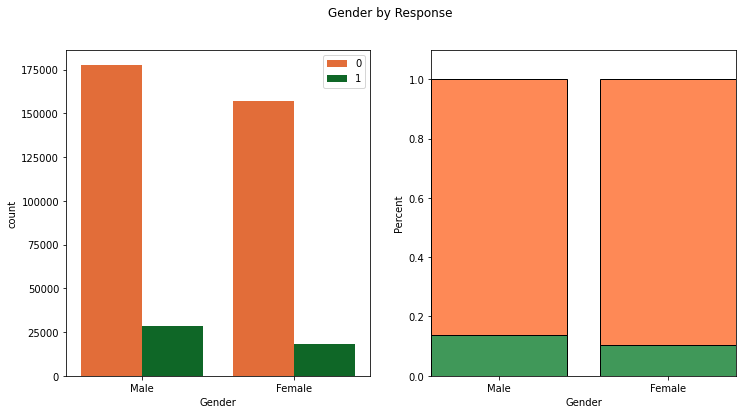

In [60]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Gender by Response')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Response'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()	

terlihat bahwa yang memiliki persentase yang lebih tinggi dibanding yang lain merupakan 'male'.

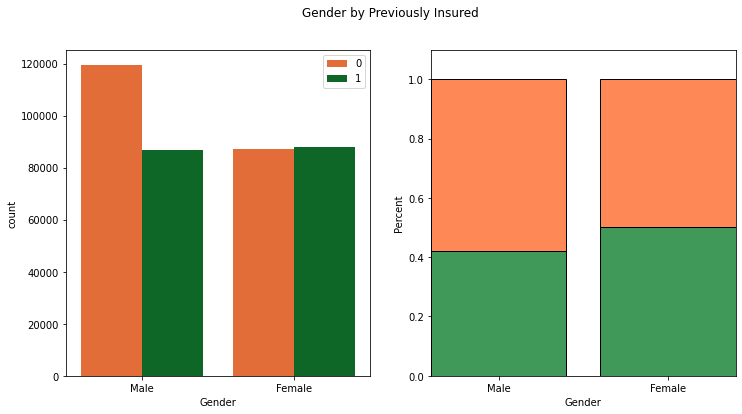

In [61]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Gender by Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Previously_Insured'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat mengapa 'male' memiliki minat vehicle insurance karena mereka sebelumnya belum memilikinya dibanding 'female' mereka sudah memiliki vehicle insurance sebelumnya.

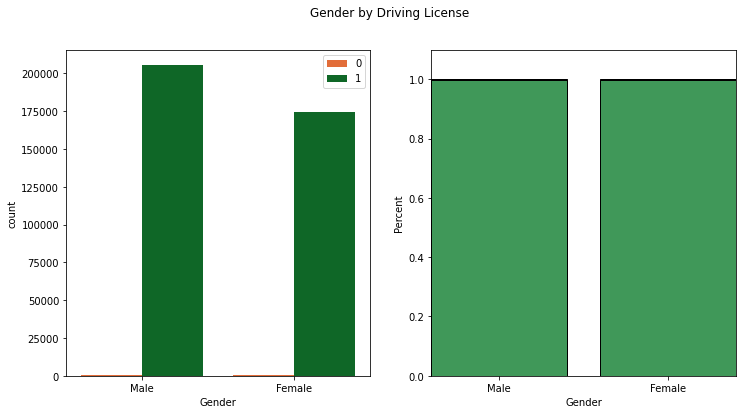

In [62]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Gender by Driving License')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Driving_License'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

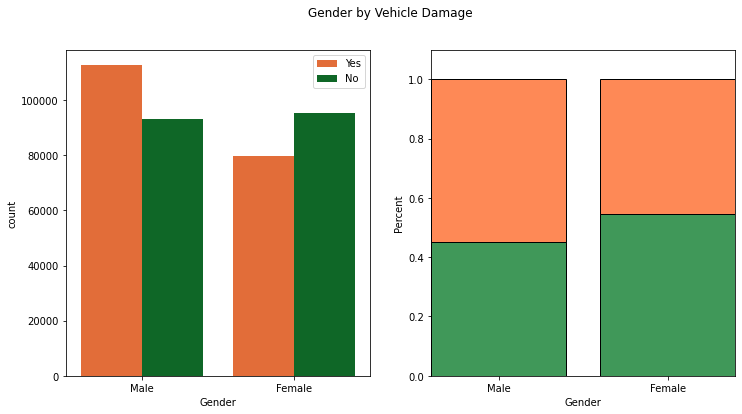

In [63]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Gender by Vehicle Damage')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Vehicle_Damage'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Vehicle_Damage'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :

- kalaupun 'female' persentase mengalami kerusakan lebih tinggi akan tetapi mereka sudah memiliki vehicle insurance sebelumnya.
- persentase 'male' mengalami kerusakan lebih kecil akan tetapi mereka belum memiliki vehicle insurance sebelumnya.

## Vehicle Age feature

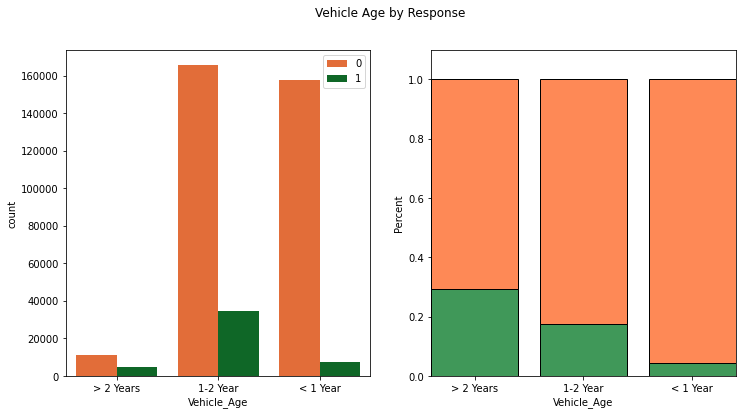

In [64]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Age by Response')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Response'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat bahwa kendaraan yang >= 1 tahun memiliki persentase yang lebih tinggi untuk memiliki vehicle insurance.

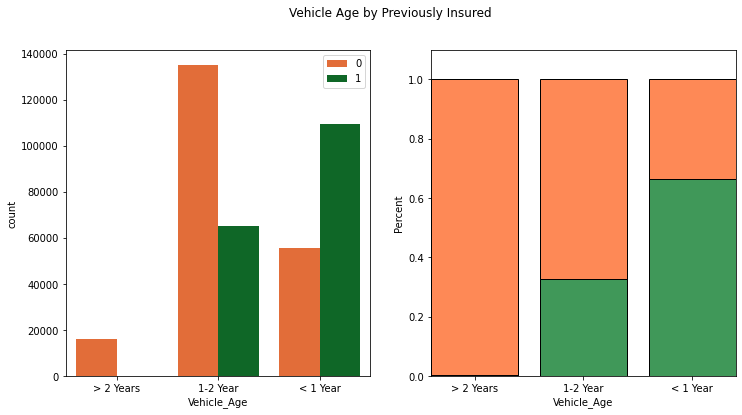

In [65]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Age by Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Previously_Insured'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas bisa diketahui bahwa :
- kendaraan yang umurnya kurang dari 1 tahun sudah memiliki vehicle insurance
- kendaraan yang umurnya 1-2 tahun memiliki vehicle insurance sebelumnya tetapi lebih sedikit
- kendaraan yang umurnya lebih dari 2 tahun tidak memiliki vehicle insurance sebelumnya

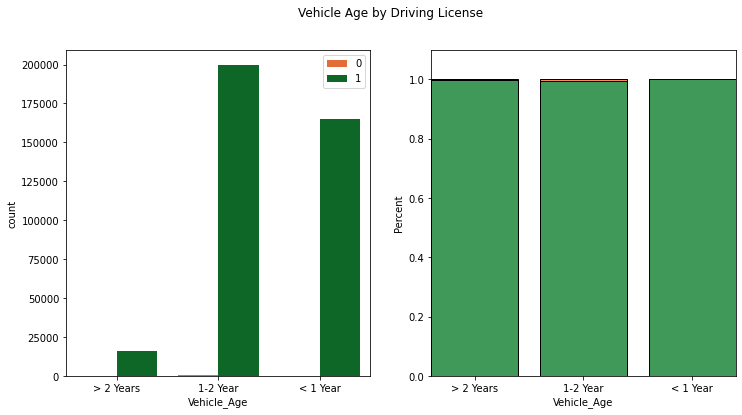

In [66]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Age by Driving License')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Driving_License'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

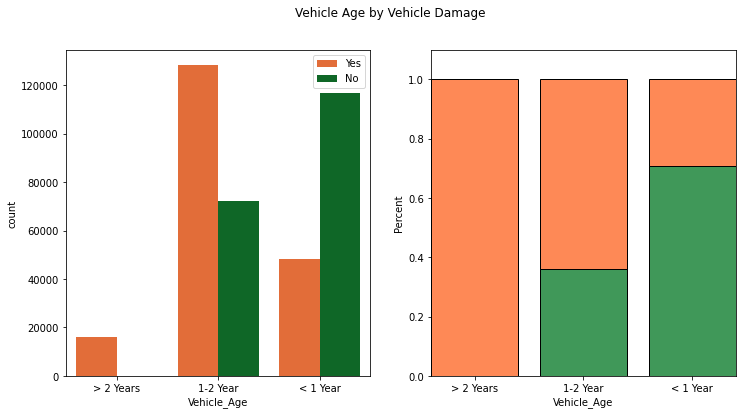

In [67]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Age by Vehicle Damage')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Vehicle_Damage'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Vehicle_Damage'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas bisa diketahui bahwa :
- akan tetapi kendaraan yang umurnya kurang dari 1 tahun lebih banyak mengalami vehicle damage
- kendaraan yang umurnya 1-2 tahun pernah mengalami vehicle damage tetapi lebih sedikit
- lebih baik kendaraan yang umurnya lebih dari 2 tahun jarang mengalami vehicle damage dan lebih menguntungkan jika bisa mendapat customer seperti ini.

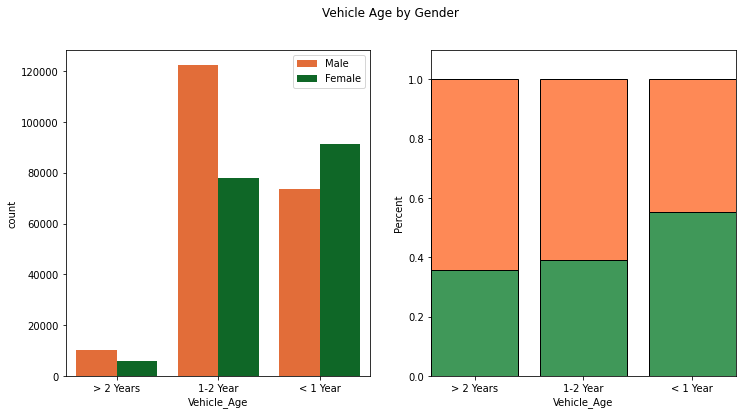

In [68]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Age by Gender')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Gender'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Gender'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat bahwa customer yang memiliki kendaraan lebih dari 2 tahun lebih banyak dimiliki oleh 'male'.

## Vehicle Damage feature

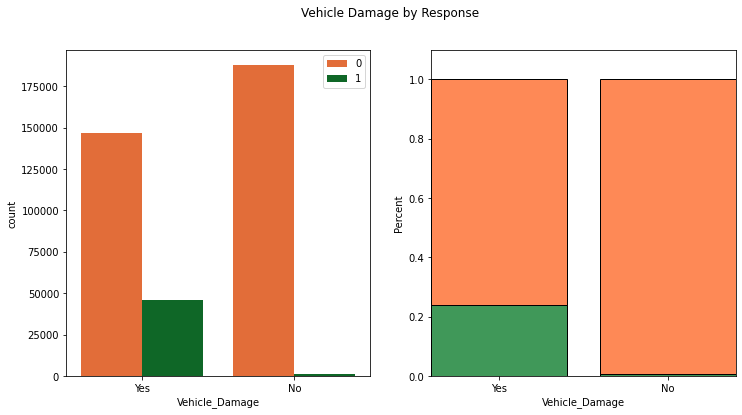

In [69]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Damage by Response')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Damage'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Damage'],
              hue=train['Response'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat bahwa kendaraan yang pernah mengalami kerusakan sebelumnya memiliki persentase yang lebih untuk memiliki vehicle insurance.

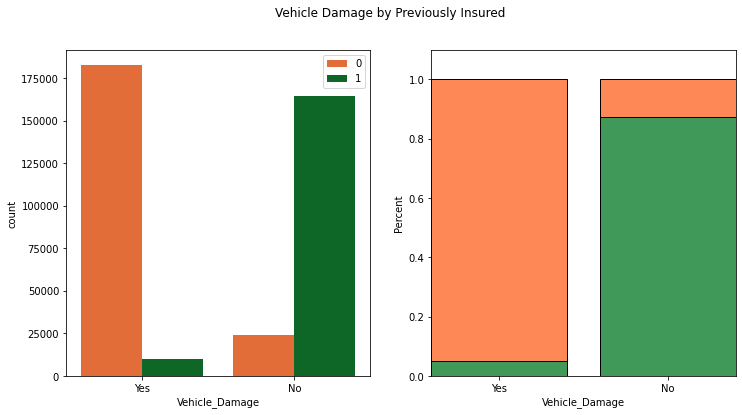

In [70]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Damage by Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Damage'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Damage'],
              hue=train['Previously_Insured'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

didukung bahwa kendaraan yang mengalami kerusakan sebelumnya juga tidak memiliki vehicle insurance sebelumnya

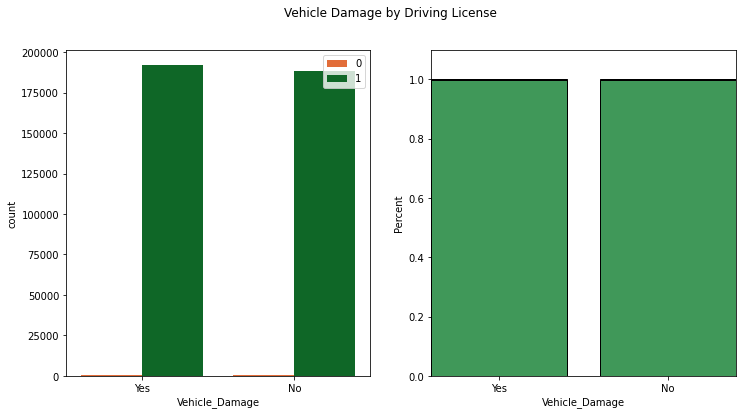

In [71]:
# proportion and percentage check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Vehicle Damage by Driving License')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Damage'],
              hue=train['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Damage'],
              hue=train['Driving_License'], stat='percent', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

## Correlation

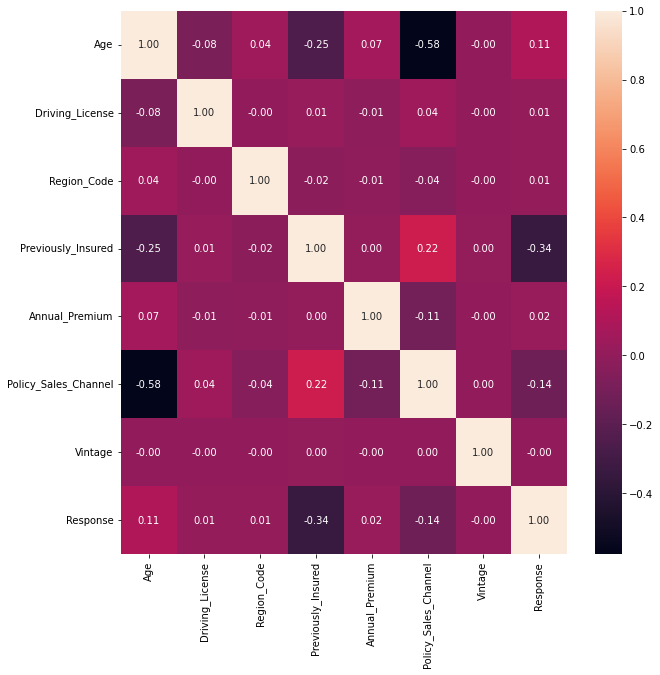

In [72]:
correlation = train[nums].corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

Vintage feature is considered to be uncorrelated, then i choose to drop it later

# Preprocessing

## Handling Outlier

In [73]:
col = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
        'Annual_Premium', 'Policy_Sales_Channel', 'Response']

In [74]:
# hitung jumlah baris sebelum deteksi outlier
print(f'Jumlah baris sebelum memfilter outlier: {len(train[col])}')

filtered_entries = np.array([True] * len(train[col]))
for col in col :
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((train[col] >= low_limit) & (train[col] <= high_limit)) & filtered_entries
    
train_clean = train[filtered_entries].reset_index()

# hitung jumlah baris setelah outlier
print(f'Jumlah baris setelah memfilter outlier: {len(train_clean)}')

Jumlah baris sebelum memfilter outlier: 381109
Jumlah baris setelah memfilter outlier: 324911


there are some outlier but in this case let it be there

## Feature Selection

In [75]:
#instead of using such as column ages and annual premium it's better to use a grouped column, then drop the unnecesary columns
train = train.drop(['Vintage', 'Age', 'Annual_Premium', 'Vintage_Month','group_vintage'], axis=1)

## Feature Encoding

In [76]:
#label encoding
train['group_ages'].replace('Young',0,inplace=True) #young -> 0
train['group_ages'].replace('Adult',1,inplace=True) #adult -> 1
train['group_ages'].replace('Middle Age',2,inplace=True) # middle age -> 2
train['group_ages'].replace('Elder',3,inplace=True) #elder -> 3
train['group_premium'].replace('Cheap',0,inplace=True) #cheap -> 0
train['group_premium'].replace('Reguler',1,inplace=True) #reguler -> 1
train['group_premium'].replace('Expensive',2,inplace=True) #expensive -> 2
train['Gender'].replace('Male',1,inplace=True) #male -> 1
train['Gender'].replace('Female',0,inplace=True)#female -> 0
train['Vehicle_Damage'].replace('Yes',1,inplace=True) #Yes -> 1
train['Vehicle_Damage'].replace('No',0,inplace=True)#No -> 0
train['Vehicle_Age'].replace('> 2 Years',0,inplace=True)# > 2 -> 2
train['Vehicle_Age'].replace('1-2 Year',1,inplace=True) # 1-2 -> 1
train['Vehicle_Age'].replace('< 1 Year',0,inplace=True)# < 1 -> 0

In [77]:
train.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response,group_ages,group_premium
0,1,1,28.0,0,0,1,26.0,1,1,2
1,1,1,3.0,0,1,0,26.0,0,3,1
2,1,1,28.0,0,0,1,26.0,1,2,1
3,1,1,11.0,1,0,0,152.0,0,0,1
4,0,1,41.0,1,0,0,152.0,0,1,1


## Scaling

In [78]:
X = train.drop(columns = 'Response')
y = train['Response']

In [79]:
X.describe()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,group_ages,group_premium
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,0.997869,26.388807,0.458210,0.525613,0.504877,112.034295,1.168498,0.971226
std,0.498336,0.046110,13.229888,0.498251,0.499344,0.499977,54.203995,0.993212,0.707275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000
50%,1.000000,1.000000,28.000000,0.000000,1.000000,1.000000,133.000000,1.000000,1.000000
75%,1.000000,1.000000,35.000000,1.000000,1.000000,1.000000,152.000000,2.000000,1.000000
max,1.000000,1.000000,52.000000,1.000000,1.000000,1.000000,163.000000,3.000000,2.000000


In [80]:
# Scaling dataframe
for col in X:
  scaler = StandardScaler()
  X[col] = scaler.fit_transform(X[col].values.reshape(len(X), 1))

In [81]:
X.describe()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,group_ages,group_premium
count,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05
mean,9.687465e-17,-9.322227e-16,1.230509e-17,7.849158e-17,-1.102238e-16,7.273056e-17,-7.644074e-17,6.734242e-17,7.692548e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.085134e+00,-2.164130e+01,-1.994638e+00,-9.196380e-01,-1.052609e+00,-1.009801e+00,-2.048455e+00,-1.176485e+00,-1.373197e+00
25%,-1.085134e+00,4.620794e-02,-8.608404e-01,-9.196380e-01,-1.052609e+00,-1.009801e+00,-1.531887e+00,-1.176485e+00,-1.373197e+00
50%,9.215448e-01,4.620794e-02,1.217845e-01,-9.196380e-01,9.500205e-01,9.902940e-01,3.867931e-01,-1.696495e-01,4.068287e-02
75%,9.215448e-01,4.620794e-02,6.508902e-01,1.087384e+00,9.500205e-01,9.902940e-01,7.373213e-01,8.371861e-01,4.068287e-02
max,9.215448e-01,4.620794e-02,1.935861e+00,1.087384e+00,9.500205e-01,9.902940e-01,9.402586e-01,1.844022e+00,1.454563e+00


## Imbalance data handling

In [82]:
# imbalance data handling menggunakan SMOTE
smote = over_sampling.SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X,y)

print(f'''shape of X before SMOTE:{X.shape}
shape of X after SMOTE:{X_smote.shape}''')

print('\nbalance of positive & negative classes (%):')
y_smote.value_counts(normalize=True)*100

shape of X before SMOTE:(381109, 9)
shape of X after SMOTE:(668798, 9)

balance of positive & negative classes (%):


1    50.0
0    50.0
Name: Response, dtype: float64

# Modelling

## Train Test Split

In [83]:
# train test split sebelum modelling
X_train, X_test,y_train,y_test = train_test_split(X_smote, y_smote,
                                                  test_size = 0.2,
                                                  random_state = 42)

In [84]:
y_train.value_counts()

0    267624
1    267414
Name: Response, dtype: int64

## Models

In [85]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [86]:
dct = DecisionTreeClassifier(random_state=42)
dct.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [87]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [88]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [89]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

# Models Evalution

performa logreg:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     66775
           1       0.71      0.98      0.82     66985

    accuracy                           0.79    133760
   macro avg       0.84      0.79      0.78    133760
weighted avg       0.83      0.79      0.78    133760



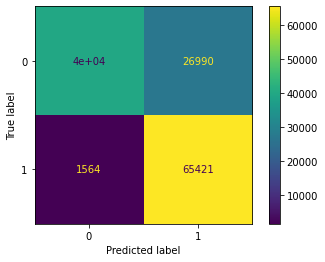


performa dct:
              precision    recall  f1-score   support

           0       0.91      0.74      0.81     66775
           1       0.78      0.93      0.85     66985

    accuracy                           0.83    133760
   macro avg       0.85      0.83      0.83    133760
weighted avg       0.85      0.83      0.83    133760



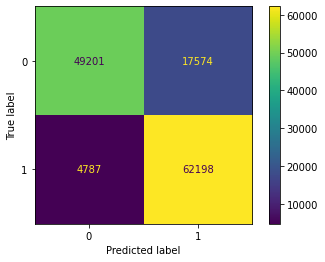


performa knn:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78     66775
           1       0.76      0.87      0.81     66985

    accuracy                           0.80    133760
   macro avg       0.81      0.80      0.80    133760
weighted avg       0.81      0.80      0.80    133760



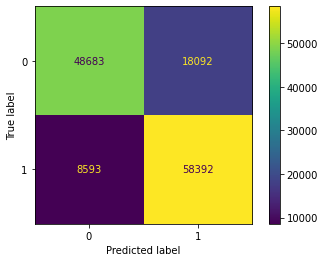


performa rfc:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81     66775
           1       0.78      0.93      0.85     66985

    accuracy                           0.83    133760
   macro avg       0.84      0.83      0.83    133760
weighted avg       0.84      0.83      0.83    133760



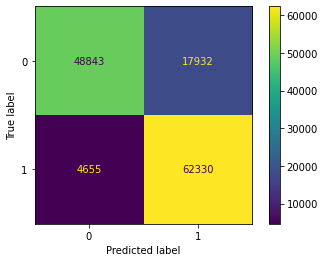


performa xgb:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80     66775
           1       0.76      0.95      0.84     66985

    accuracy                           0.83    133760
   macro avg       0.85      0.83      0.82    133760
weighted avg       0.85      0.83      0.82    133760



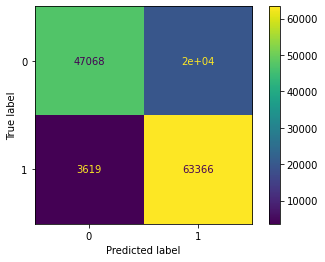

In [90]:
models = [logreg, dct, knn, rfc, xgb]
str_model = ['logreg', 'dct', 'knn', 'rfc', 'xgb']

for model, str_mod in zip(models, str_model):
  prediction = model.predict(X_test)
  cm = confusion_matrix(y_test, prediction,labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  print(f'performa {str_mod}:')
  #print(confusion_matrix(y_test, prediction))
  print(classification_report(y_test, prediction))
  disp.plot()
  plt.show()
  print()

# Model validation

In [91]:
kfold = model_selection.KFold(n_splits=10,shuffle=True,
                              random_state=42)

In [92]:
for model,str_mod in zip(models, str_model):
  result = model_selection.cross_val_score(model, X_smote, y_smote, cv=kfold,
                                           scoring='f1')
  print(f'Model {str_mod}:')
  print('f1-score :%.2f%% (%.2f%%)' % (result.mean()*100, result.std()*100))

Model logreg:
f1-score :81.90% (0.18%)
Model dct:
f1-score :84.74% (0.18%)
Model knn:
f1-score :43.97% (0.88%)
Model rfc:
f1-score :84.63% (0.17%)
Model xgb:
f1-score :84.34% (0.14%)


# Hyperparameter Tuning


In [93]:
dct.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [94]:
# specify the hyperparameter grid to search over
param_grid = {'max_depth': [1, 5, 10, 15, 20, 25, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 2, 4, 6, 8]}

# create the grid search object
grid_search = GridSearchCV(dct, param_grid, scoring='f1', cv=5)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# get the best hyperparameters and the best cross-validation score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [95]:
best_params

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [96]:
best_score

0.8411025378325316

In [97]:
# fungsi untuk evaluasi model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    cm = confusion_matrix(y_test, predictions,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    # print classification report
    print(classification_report(test_labels, predictions))
    disp.plot()
    plt.show()
    print()

              precision    recall  f1-score   support

           0       0.91      0.74      0.81     66775
           1       0.78      0.93      0.85     66985

    accuracy                           0.83    133760
   macro avg       0.85      0.83      0.83    133760
weighted avg       0.85      0.83      0.83    133760



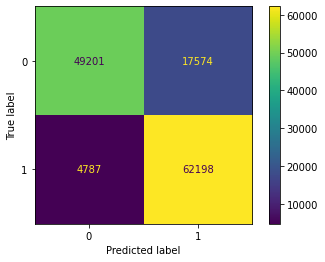


              precision    recall  f1-score   support

           0       0.91      0.73      0.81     66775
           1       0.78      0.93      0.84     66985

    accuracy                           0.83    133760
   macro avg       0.84      0.83      0.83    133760
weighted avg       0.84      0.83      0.83    133760



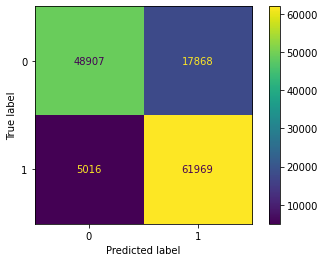

In [98]:
#evaluasi base model dct
base_dct = DecisionTreeClassifier(random_state = 42)
base_dct.fit(X_train, y_train)
base_accuracy = evaluate(base_dct, X_test, y_test)
# dengan best parameter dct
best_grid = grid_search.best_estimator_
random_accuracy = evaluate(best_grid, X_test, y_test)

diketahui bahwa tidak selamanya model dengan hyperparameter tuning lebih baik di banding base model decision tree classifier.

# Features Importance

In [99]:
importances = best_grid.feature_importances_

In [100]:
features = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

In [101]:
features

,feature,importance
0,Gender,0.007473
1,Driving_License,0.001077
2,Region_Code,0.131685
3,Previously_Insured,0.178473
4,Vehicle_Age,0.069638
5,Vehicle_Damage,0.308780
6,Policy_Sales_Channel,0.248421
7,group_ages,0.047205
8,group_premium,0.007248


In [102]:
features = features.sort_values(by='importance', ascending=True)

In [103]:
features

,feature,importance
1,Driving_License,0.001077
8,group_premium,0.007248
0,Gender,0.007473
7,group_ages,0.047205
4,Vehicle_Age,0.069638
2,Region_Code,0.131685
3,Previously_Insured,0.178473
6,Policy_Sales_Channel,0.248421
5,Vehicle_Damage,0.308780


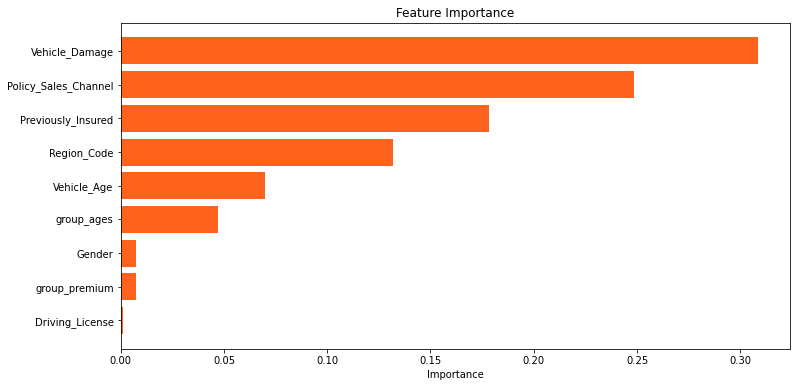

In [104]:
plt.subplots(figsize=(12,6))

plt.barh(features['feature'], features['importance'], color = '#fe621d')
plt.xlabel('Importance')
plt.title('Feature Importance')

# Show the plot
plt.show()

berdasarkan features importance, fitur vintage yang paling berpengaruh, lalu jumlah annual premium, kemudian age. sehingga perusahaan dapat menaruh fokus pada fitur - fitur tersebut.